## Importing the Used Packages

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy.stats import qmc 
from scipy.stats import multivariate_normal


## Question 1 — Implementation of an Alpha-Stable Distribution Generator

### Objective 
The first step involves implementing a generator that simulates random variables following an alpha-stable distribution 
𝑆
(
𝛼
,
𝛽
,
𝜎
,
𝜇
), as described in Appendix B of Sisson (2011).
The algorithm used follows the approach of Chambers, Mallows, and Stuck (1976), which relies on the transformation of two elementary distributions.


In [ ]:
def sample_alpha_stable(alpha, beta, gamma=1, delta=0, size=1):
    U = np.pi * (np.random.rand(size) - 0.5)  # Uniforme sur (-π/2, π/2)
    W = np.random.exponential(scale=1.0, size=size)  # Exp(1)

    if alpha != 1:
        numerator = np.sin(alpha * U)
        denominator = (np.cos(U))**(1 / alpha)
        inner = np.cos((1 - alpha) * U) / W
        X = numerator / denominator * (inner) ** ((1 - alpha) / alpha)
    else:
        B = (2 / np.pi) * ((np.pi / 2) + beta * U) * np.tan(U) - \
            beta * np.log((np.pi / 2 * W * np.cos(U)) / ((np.pi / 2) + beta * U))
        X = B

    return gamma * X + delta



### Why is this generator is valid ? 
#### a- Empirical Validation: Visualization of Some Distributions
We test the generator for different values of 
𝛼
and 
𝛽, by presenting the histograms of the simulated samples.



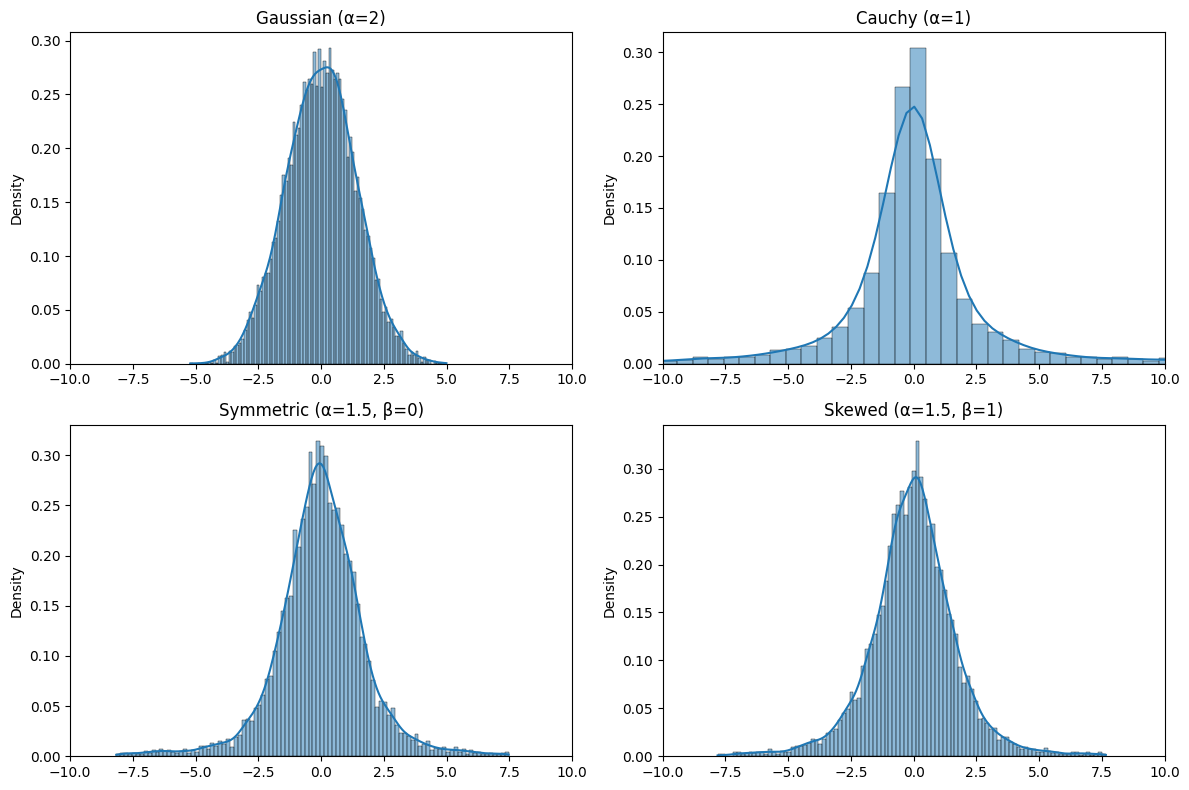

In [ ]:
# Paramètres à tester
params = [
    (2.0, 0, 1, 0, 'Gaussian (α=2)'),
    (1.0, 0, 1, 0, 'Cauchy (α=1)'),
    (1.5, 0, 1, 0, 'Symmetric (α=1.5, β=0)'),
    (1.5, 1, 1, 0, 'Skewed (α=1.5, β=1)'),
]

fig, axs = plt.subplots(2, 2, figsize=(12, 8))
axs = axs.flatten()

for i, (alpha, beta, gamma, delta, title) in enumerate(params):
    data = sample_alpha_stable(alpha, beta, gamma, delta, size=10000)
    
    # On élimine les valeurs extrêmes (1% aux deux extrémités) pour les cas Cauchy et Skewed
    if alpha <= 1.5:
        lower, upper = np.percentile(data, 1), np.percentile(data, 99)
        data = data[(data >= lower) & (data <= upper)]
    
    sns.histplot(data, kde=True, stat='density', ax=axs[i], bins=100)
    axs[i].set_title(title)
    axs[i].set_xlim(-10, 10)
    axs[i].set_xlabel("")
    axs[i].set_ylabel("Density")

plt.tight_layout()
plt.show()


#### b- Validation via the Characteristic Function
Another way to test the validity of the generator is to compare the empirical characteristic function.

Since the density of alpha-stable distributions is generally not available in closed form (except in particular cases), it cannot be directly compared to an empirical estimate. However, their characteristic function (CF) is explicitly known and serves as an effective tool for numerically validating an alpha-stable random variable generator.

##### Definition
The characteristic function of a random variable 
𝑋 is defined by: 
$$
\varphi_X(t) = \mathbb{E}[e^{itX}]
$$

For X∼S(α,β,γ,δ), the theoretical characteristic function is:

- if  $ \alpha \neq 1 $ :

$$
\varphi_X(t) = \exp\left( -\gamma^\alpha |t|^\alpha \left[ 1 - i\beta\, \text{sign}(t) \tan\left( \frac{\pi \alpha}{2} \right) \right] + i \delta t \right)
$$

- if  $ \alpha = 1 $ :

$$
\varphi_X(t) = \exp\left( -\gamma |t| \left[ 1 + i\beta \frac{2}{\pi} \, \text{sign}(t) \log|t| \right] + i \delta t \right)
$$

##### Method
We generate a large number of observations $ X_1, \dots, X_N $ using the generator, and then compute the empirical estimator. 
We then compare the results obtained through the curves:

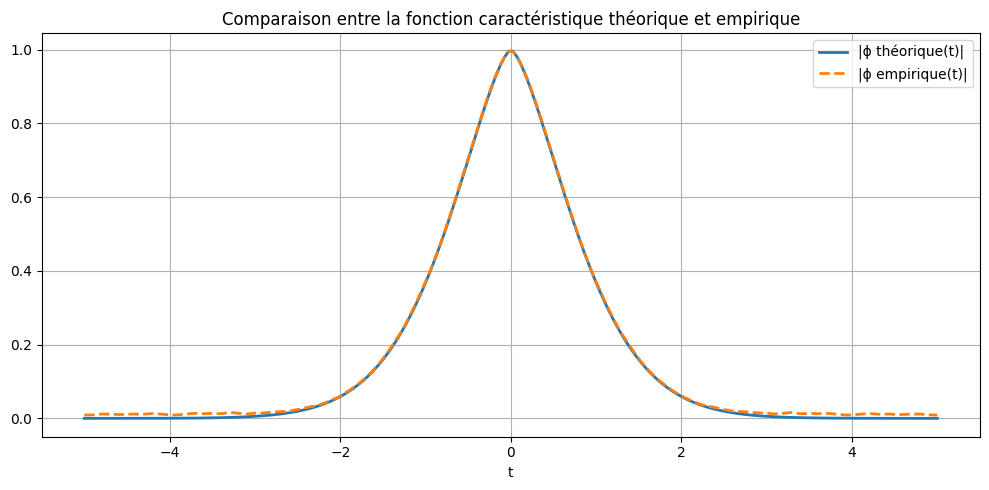

In [ ]:
# Fonction caractéristique théorique
def theoretical_cf(t, alpha, beta, gamma=1, delta=0):
    if alpha != 1:
        return np.exp(
            -gamma**alpha * np.abs(t)**alpha *
            (1 - 1j * beta * np.sign(t) * np.tan(np.pi * alpha / 2)) +
            1j * delta * t
        )
    else:
        return np.exp(
            -gamma * np.abs(t) *
            (1 + 1j * beta * (2 / np.pi) * np.sign(t) * np.log(np.abs(t))) +
            1j * delta * t
        )

# Estimateur empirique de la fonction caractéristique
def empirical_cf(t_vals, samples):
    return np.array([np.mean(np.exp(1j * t * samples)) for t in t_vals])

# Paramètres de test
alpha = 1.5
beta = 0
gamma = 1
delta = 0
N = 10_000

# Génération d'échantillons
samples = sample_alpha_stable(alpha, beta, gamma, delta, size=N)

# Grille de t
t_vals = np.linspace(-5, 5, 200)

# Fonction caractéristique théorique et empirique
phi_theo = theoretical_cf(t_vals, alpha, beta, gamma, delta)
phi_emp = empirical_cf(t_vals, samples)

# Tracé des modules
plt.figure(figsize=(10, 5))
plt.plot(t_vals, np.abs(phi_theo), label="|ϕ théorique(t)|", lw=2)
plt.plot(t_vals, np.abs(phi_emp), label="|ϕ empirique(t)|", lw=2, linestyle="--")
plt.xlabel("t")
plt.title("Comparaison entre la fonction caractéristique théorique et empirique")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## Question 2 — RQMC 

In this section, we will adapt our alpha-stable generator using **RQMC points** (Randomized Quasi-Monte Carlo). We will then compare the results obtained using RQMC with those from standard Monte Carlo.

RQMC generators, such as Sobol, are designed to distribute sampling points more uniformly in space, which allows for better coverage of the integration interval with fewer points, while maintaining the statistical properties of interest. This leads to a more accurate estimation of integrals, which is particularly useful in the simulation of alpha-stable distributions.

The idea here is to **generate the uniform points** needed to transform these points into variables following a **uniform distribution** over the interval $ (-\pi/2, \pi/2) $ , and then generate an **exponential distribution**.

- **Uniform distribution**: This is quite simple to implement by directly using the points generated by RQMC, which are uniformly distributed in the interval $[0, 1]$ . By transforming them appropriately, we obtain uniformly distributed points in the interval $ (-\pi/2, \pi/2) $.

- **Exponential distribution**: To generate the exponential distribution, we used the **inversion theorem**. Given that if $ U \sim \text{Uniform}(0, 1) $ , the inverse transformation $ W = -\log(1 - U) $ allows us to obtain a variable following an exponential distribution with rate parameter $ \lambda = 1 $.


In [6]:
# Générateur RQMC
def generate_rqmc_points(n_samples, dim):
    """
    Génère des points RQMC (par exemple, avec la suite de Sobol) dans un espace [0, 1].
    """
    sampler = qmc.Sobol(d=dim, scramble=True)
    points = sampler.random(n_samples)
    return points

def sample_alpha_stable_with_rqmc(alpha, beta, gamma=1, delta=0, size=1):
    """
    Génère des échantillons alpha-stables à l'aide de RQMC pour générer des points uniformes et exponentiels.
    """
    # Utilisation de RQMC pour générer des points
    rqmc_points = generate_rqmc_points(size, 1) 
    
    # Transformation pour obtenir la loi uniforme U sur (-pi/2, pi/2)
    U = np.pi * (rqmc_points - 0.5) 
    
    # Transformation inverse pour obtenir W suivant une loi exponentielle
    W = -np.log(1 - rqmc_points)  # D'après théorème de l'inversion

    # Calcul de l'échantillon alpha-stable
    if alpha != 1:
        numerator = np.sin(alpha * U)
        denominator = (np.cos(U))**(1 / alpha)
        inner = (np.cos((1 - alpha) * U)) / W
        X = numerator / denominator * (inner ** ((1 - alpha) / alpha))
    else:
        B = (2 / np.pi) * ((np.pi / 2) + beta * U) * np.tan(U) - \
            beta * np.log((np.pi / 2) * W * np.cos(U)) / ((np.pi / 2) + beta * U)
        X = B

    # Retourner l'échantillon alpha-stable final avec les paramètres gamma et delta
    return gamma * X + delta

### Comparison Between Monte Carlo and RQMC Estimations

In this section, we will compare the estimations by **Monte Carlo (MC)** and **Randomized Quasi-Monte Carlo (RQMC)**. We have chosen to take a **Cauchy distribution**, which is a special case of alpha-stable distributions, and the function $ f(x) = e^{-x^2} $. The choice of this function is primarily motivated by the fact that this function allows the expectation of $ f(X) $ to be convergent when $ X $ follows a **Cauchy distribution**. Moreover, the value of this expectation is well-known and has been extensively studied in the Mathematics literature. It is approximately equal to the constant $ 0.4275835762 $.

The objective is to observe how each method performs in estimating this expectation.


In [7]:
import warnings

# Ignorer les avertissements de SciPy concernant les points Sobol
warnings.filterwarnings("ignore", message="The balance properties of Sobol' points require n to be a power of 2")


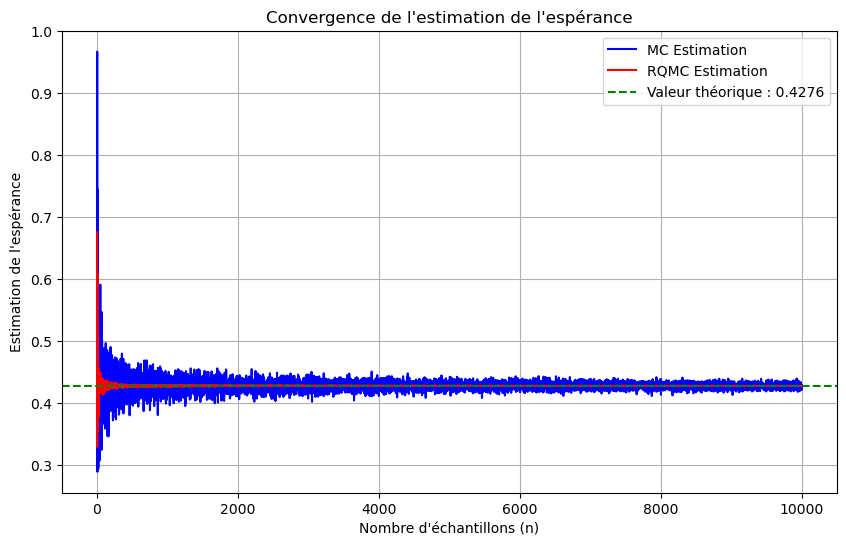

MSE Monte Carlo : 0.00014790614755297285
MSE RQMC : 1.4163075991967313e-05


In [11]:
# Fonction à évaluer 
def f(x):
    return np.exp(-x**2)

# Paramètres de la loi normale
mu = 0  # Moyenne
sigma = 1  # Ecart-type
max_samples = 10000  # Nombre maximal d'échantillons

# Variables pour stocker les résultats
mc_estimations = []
rqmc_estimations = []
# Loi cauchy
delta = 0  
gamma = 1  
alpha = 1 
beta = 0
# Valeur théorique à retrouver
theoretical_expectation = 0.4275835762
for n in range(1, max_samples + 1):
    # Estimation MC
    samples_mc = sample_alpha_stable(alpha, beta, gamma, delta, n)
    mc_estimations.append(np.mean(f(samples_mc)))
    
    # Estimation RQMC
    samples_rqmc = sample_alpha_stable_with_rqmc(alpha, beta, gamma, delta, n)
    rqmc_estimations.append(np.mean(f(samples_rqmc)))
# Plot des résultats
plt.figure(figsize=(10, 6))
plt.plot(range(1, max_samples + 1), mc_estimations, label="MC Estimation", color='blue')
plt.plot(range(1, max_samples + 1), rqmc_estimations, label="RQMC Estimation", color='red')

plt.axhline(y=theoretical_expectation, color='green', linestyle='--', label=f"Valeur théorique : {theoretical_expectation:.4f}")

plt.title("Convergence de l'estimation de l'espérance")
plt.xlabel("Nombre d'échantillons (n)")
plt.ylabel("Estimation de l'espérance")
plt.legend()
plt.grid(True)
plt.show()

# Calcul de l'erreur quadratique moyenne (MSE) par rapport à la valeur théorique
mse_mc = np.mean((np.array(mc_estimations) - theoretical_expectation)**2)
mse_rqmc = np.mean((np.array(rqmc_estimations) - theoretical_expectation)**2)

print(f"MSE Monte Carlo : {mse_mc}")
print(f"MSE RQMC : {mse_rqmc}")

We estimated $ \varphi_X(t) = \mathbb{E}[f(X)] $ with $ X $ following a Cauchy distribution. The graph above shows the evolution of the estimation of the expectation as the number of samples increases.

- **Monte Carlo (MC)** shows significant oscillations, particularly at the beginning.
- **Quasi-Monte Carlo (RQMC)**, on the other hand, presents much smoother convergence, with more stable results from the first samples.

#### Mean Squared Error (MSE)

To quantify the precision of the estimates, we calculated the mean squared error (MSE) for each method relative to the theoretical value of the expectation ( $ \approx 0.4276 $ ):

- The **RQMC method** gives a much lower MSE than **Monte Carlo**, indicating better precision with fewer samples.
#### Variances
Furthermore, to make a more precise comparison, it is essential to examine the variances of the obtained estimates. To do this, we will fix a number of samples and proceed to generate the estimates **500 times** for each method. We will then calculate the variances associated with each method to evaluate the dispersion of the results.


In [9]:
n_samples = 2**12 # Fixer le nombre d'échantillons
n_repeats = 500    # Nombre de répétitions pour chaque méthode
mc_estimations = []
rqmc_estimations = []
delta = 0  
gamma = 1  
alpha = 1 
beta = 0

# Répéter les simulations et stocker les résultats dans des tableaux
for i in range(n_repeats):
    samples_mc = sample_alpha_stable(alpha, beta, gamma, delta, n_samples)
    mc_estimations.append(np.mean(f(samples_mc)))
    
    # Estimation RQMC
    samples_rqmc = sample_alpha_stable_with_rqmc(alpha, beta, gamma, delta, n_samples)
    rqmc_estimations.append(np.mean(f(samples_rqmc)))
    
var_mc= np.var(mc_estimations)
var_rqmc= np.var(rqmc_estimations)
print("La variance de MC standard est", var_mc,"\n La variance de RQMC est", var_rqmc)

La variance de MC standard est 3.590695835066934e-05 
 La variance de RQMC est 1.6469412580119295e-11


The results show that the variance of Monte Carlo (MC) is much higher than that of RQMC. This means that MC estimates are more dispersed, while those from RQMC are more stable and precise.

We conclude that RQMC provides more consistent results and converges more rapidly to the theoretical value. This aligns well with what we saw in the course, where RQMC is presented as a more effective method for reducing error and obtaining more precise results compared to Monte Carlo.


## Question 3 — ABC Algorithms
The objective of the question is to properly implement the methods used in the Article. ABC algorithm, also refered as Likelihood-free Bayesian inference in the paper, permits simulation from an approximate posterior model while circumventing explicite valuation of the like likelyhood function.
In the context of alpha-stable random variables, it is impossible to directly compute 
$p(y∣θ)$ , and thus, one cannot obtain the target posterior distribution $π(θ∣y)$. This necessitates the use of ABC rejection.

### A- ABC Reject Algorithm 

In [3]:
# ——————————————————————————————————————————————
# 1. Statistiques de résumé S₁ (McCulloch)
# ——————————————————————————————————————————————

def mcculloch_stats(data, gamma):
    """
    Calcule les 4 statistiques de McCulloch pour une série `data` :
      - v_alpha = (q95 − q05) / (q75 − q25)
      - v_beta  = (q95 + q05 − 2 q50) / (q95 − q05)
      - v_gamma = (q75 − q25) / gamma
      - v_delta = mean(data)
    
    Paramètres
    ----------
    data : array-like
        Jeu de données simulées ou observées.
    gamma : float
        Valeur de gamma utilisée pour normaliser v_gamma.
    
    Retour
    ------
    dict
        {
          "v_alpha": ...,
          "v_beta" : ...,
          "v_gamma": ...,
          "v_delta": ...
        }
    """
    # Calcul des quantiles nécessaires
    q05, q25, q50, q75, q95 = np.quantile(data, [0.05, 0.25, 0.50, 0.75, 0.95])
    
    # Formules de McCulloch
    v_alpha = (q95 - q05) / (q75 - q25)
    v_beta  = (q95 + q05 - 2 * q50) / (q95 - q05)
    v_gamma = (q75 - q25) / gamma
    v_delta = np.mean(data)
    
    return {
        "v_alpha": v_alpha,
        "v_beta" : v_beta,
        "v_gamma": v_gamma,
        "v_delta": v_delta
    }

In [4]:
def abc_reject(y_star, alpha_range, beta_range, gamma_range, delta_range, n_samples, epsilon):
    """
    Algorithme ABC-rejection pour estimer les paramètres (alpha, beta, gamma, delta)
    d'une loi alpha-stable, en comparant les statistiques de McCulloch.

    Retourne également les MMSE des paramètres et leurs écarts-types, et affiche leurs distributions.
    """
    accepted_samples = []
    rejections = 0
    acceptances = 0
    gamma_obs = 10.0

    # Statistiques McCulloch observées
    y_star_mcculloch = mcculloch_stats(y_star, gamma=gamma_obs)
    print("Statistiques McCulloch observées :", y_star_mcculloch)

    keys = ['v_alpha', 'v_beta', 'v_gamma', 'v_delta']

    # Boucle ABC-reject
    while len(accepted_samples) < n_samples:
        alpha = np.random.uniform(*alpha_range)
      
        beta  = np.random.uniform(*beta_range)
      
        gamma = np.random.uniform(*gamma_range)
        delta = np.random.uniform(*delta_range)

        y_sim = sample_alpha_stable(alpha, beta, gamma, delta, size=len(y_star))
        sim_stats = mcculloch_stats(y_sim, gamma=gamma)

        sim_vec = np.array([sim_stats[k] for k in keys])
        obs_vec = np.array([y_star_mcculloch[k] for k in keys])
        distance = np.linalg.norm(sim_vec - obs_vec)
        

        if distance < epsilon:
            accepted_samples.append({'alpha': alpha, 'beta': beta,
                                     'gamma': gamma, 'delta': delta,
                                     'distance': distance, 'sim_stats': sim_stats})
            acceptances += 1
        else:
            rejections += 1

    # Graphique acceptations vs rejets
    plt.figure(figsize=(6,4))
    plt.bar(['Acceptations','Rejets'], [acceptances,rejections], color=['green','red'])
    plt.title("ABC Reject : Acceptations vs Rejets")
    plt.ylabel("Nombre")
    plt.show()

    # Extraction des paramètres acceptés
    alphas = [s['alpha'] for s in accepted_samples]
    betas  = [s['beta']  for s in accepted_samples]
    gammas = [s['gamma'] for s in accepted_samples]
    deltas = [s['delta'] for s in accepted_samples]

    # Calcul des MMSE (mean of accepted) et leurs écarts-types
    mmse_alpha = np.mean(alphas)
    mmse_beta  = np.mean(betas)
    mmse_gamma = np.mean(gammas)
    mmse_delta = np.mean(deltas)
    
    std_alpha = np.std(alphas)
    std_beta  = np.std(betas)
    std_gamma = np.std(gammas)
    std_delta = np.std(deltas)
    
    print(f"MMSE estimates -> alpha: {mmse_alpha:.4f} ({std_alpha:.4f}), beta: {mmse_beta:.4f} ({std_beta:.4f}), gamma: {mmse_gamma:.4f} ({std_gamma:.4f}), delta: {mmse_delta:.4f} ({std_delta:.4f})")

    # Affichage des distributions
    fig, axes = plt.subplots(2, 2, figsize=(10,8))
    axes = axes.flatten()
    axes[0].hist(alphas, bins=20)
    axes[0].set_title('Distribution de alpha')
    axes[1].hist(betas, bins=20)
    axes[1].set_title('Distribution de beta')
    axes[2].hist(gammas, bins=20)
    axes[2].set_title('Distribution de gamma')
    axes[3].hist(deltas, bins=20)
    axes[3].set_title('Distribution de delta')
    for ax in axes:
        ax.set_xlabel('Valeur')
        ax.set_ylabel('Fréquence')
    plt.tight_layout()
    plt.show()

    return accepted_samples, {'mmse': {'alpha': mmse_alpha, 'beta': mmse_beta,
                                      'gamma': mmse_gamma, 'delta': mmse_delta},
                            'std': {'alpha': std_alpha, 'beta': std_beta,
                                   'gamma': std_gamma, 'delta': std_delta}}

Statistiques McCulloch observées : {'v_alpha': 2.7583154753323247, 'v_beta': -0.006352464330587786, 'v_gamma': 1.8527210794181606, 'v_delta': 9.276579870695521}


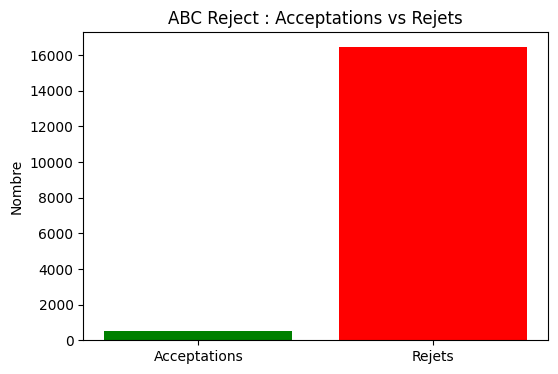

MMSE estimates -> alpha: 1.6697 (0.1868), beta: -0.0364 (0.5786), gamma: 7.4828 (4.1513), delta: 9.3551 (1.2911)


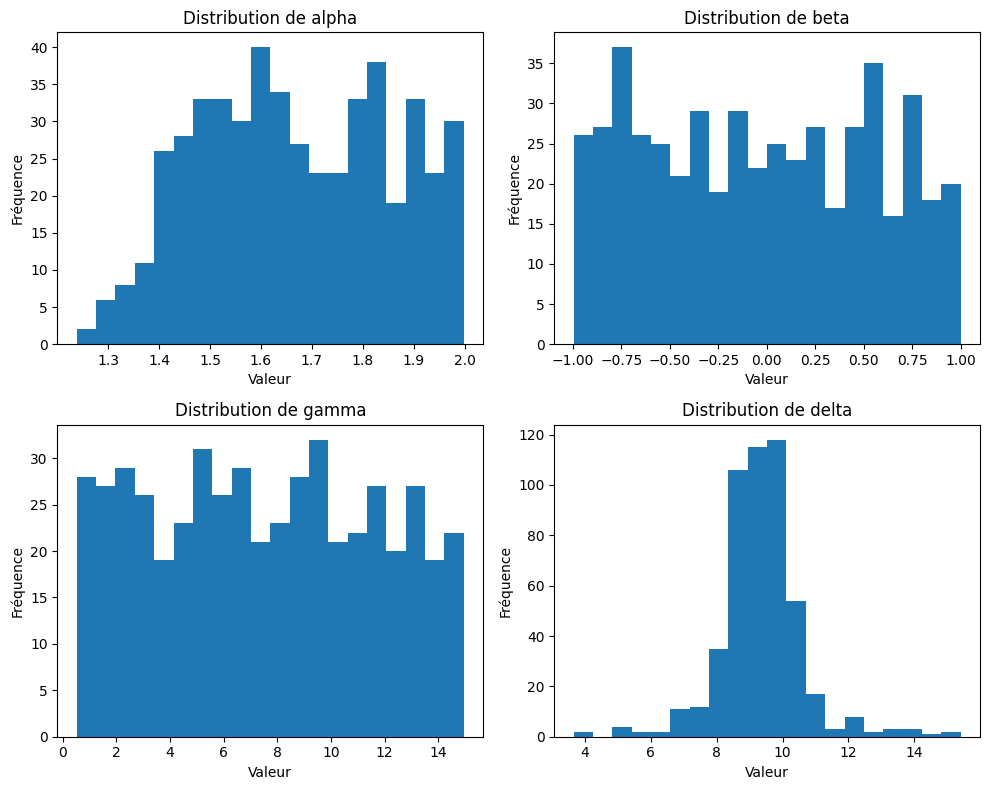

In [11]:
# Generate a set of observed data
y_star = sample_alpha_stable(1.7, 0.9, 10, 10, size=1000)

# Run ABC rejection sampling
accepted_samples = abc_reject(
    y_star=y_star,
    alpha_range=(1.0, 2.0),
    beta_range=(-1.0, 1.0),
    gamma_range=(0.5, 15),
    delta_range=(-20, 20),
    n_samples=500,
    epsilon=1
)


The MMSE estimates reveal a good estimation of 
α and 
δ. However, the number of rejections is high, making the process computationally expensive. On the other hand, we did not apply a kernel.




### B- ABC - MCMC

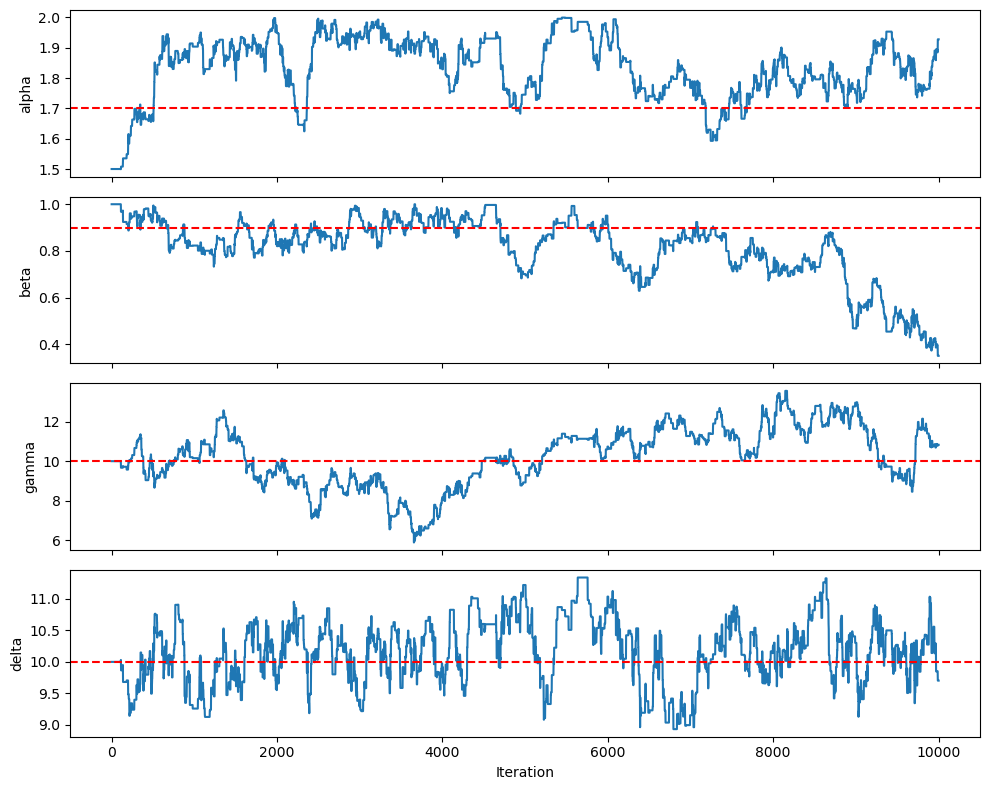

In [5]:
# ABC-MCMC avec noyau gaussien
def abc_mcmc_gaussian_kernel(y_star, start_params, n_iter, epsilon, proposal_scale):
    gamma_obs = start_params[2]
    s1_star = mcculloch_stats(y_star, gamma=gamma_obs)
    
    # Extraire les valeurs du dictionnaire s1_star et s1_sim
    s1_star_values = np.array(list(s1_star.values())) 
    
    chain = [start_params]
    for i in range(n_iter):
        current = chain[-1]
        proposal = np.random.normal(current, proposal_scale)

        alpha_p, beta_p, gamma_p, delta_p = proposal
        if not (0 < alpha_p <= 2 and -1 <= beta_p <= 1 and gamma_p > 0):
            chain.append(current)
            continue

        y_sim = sample_alpha_stable(alpha_p, beta_p, gamma_p, delta_p, size=len(y_star))
        s1_sim = mcculloch_stats(y_sim, gamma=gamma_p)
        
        # Extraire les valeurs du dictionnaire s1_sim
        s1_sim_values = np.array(list(s1_sim.values()))  

        # Calcul de la distance entre les valeurs extraites
        distance = np.linalg.norm(s1_sim_values - s1_star_values)

        # Utilisation explicite du noyau gaussien
        accept_prob = np.exp(- (distance ** 2) / (2 * epsilon ** 2))
        if np.random.rand() < accept_prob:
            chain.append(proposal)
        else:
            chain.append(current)
    
    return np.array(chain)
# Exemple : données observées
np.random.seed(42)
y_star = sample_alpha_stable(alpha=1.7, beta=0.9, gamma=10, delta=10, size=1000)

# Lancer MCMC-ABC avec noyau gaussien
start_params = [1.5, 1.0, 10.0, 10.0]
n_iter = 10000
epsilon = 0.2
proposal_scale = [0.02, 0.02, 0.2, 0.2]

chain = abc_mcmc_gaussian_kernel(y_star, start_params, n_iter, epsilon, proposal_scale)

# Visualisation des traces
fig, axes = plt.subplots(4, 1, figsize=(10, 8), sharex=True)
labels = ['alpha', 'beta', 'gamma', 'delta']
for i in range(4):
    axes[i].plot(chain[:, i])
    axes[i].axhline([1.7, 0.9, 10, 10][i], color='red', linestyle='--')
    axes[i].set_ylabel(labels[i])
axes[-1].set_xlabel('Iteration')
plt.tight_layout()
plt.show()

### C- SMC-ABC Algorithm

In [9]:
from scipy.stats import multivariate_normal

In [10]:
# ——————————————————————————————————————————————
# 2. Estimation de Σ̂ via P tirages à θ̂
# ——————————————————————————————————————————————

def estimate_covariance_s1(theta_hat, P=1000, size=1000):
    """
    Estime la covariance des statistiques S1 sous θ̂.
    
    Paramètres :
    - theta_hat : dictionnaire avec les paramètres (alpha, beta, gamma, delta)
    - P : nombre de simulations à effectuer (par défaut 1000)
    - size : taille de chaque échantillon simulé (par défaut 1000)
    
    Retour :
    - cov_matrix : matrice de covariance (3x3) des statistiques S1 = (v_alpha, v_beta, v_gamma)
    """
    samples = []
    for _ in range(P):
        y_sim = sample_alpha_stable(
            alpha=theta_hat["alpha"],
            beta=theta_hat["beta"],
            gamma=theta_hat["gamma"],
            delta=theta_hat["delta"],
            size=size
        )
        s = mcculloch_stats(y_sim, gamma=theta_hat["gamma"])
        samples.append([s["v_alpha"], s["v_beta"], s["v_gamma"], s["v_delta"]])
    samples = np.array(samples)
    return np.cov(samples, rowvar=False)

In [11]:
def gaussian_kernel_s1(s_obs, s_sim, epsilon, cov_matrix):
    """
    Implémentation du noyau gaussien selon la définition de l'article :
    S(y) ~ N(S(x), ε²Σ̂)
    où Σ̂ est estimée par estimate_covariance_s1 sous θ̂
    """
    # Convertir les dictionnaires en vecteurs
    obs_vec = np.array([s_obs['v_alpha'], s_obs['v_beta'], s_obs['v_gamma'], s_obs['v_delta']])
    sim_vec = np.array([s_sim['v_alpha'], s_sim['v_beta'], s_sim['v_gamma'], s_sim['v_delta']])
    
    # Calculer la différence
    diff = obs_vec - sim_vec
    
    # La matrice de covariance est déjà ε²Σ̂
    # Calculer l'exponentielle de la forme quadratique
    exponent = -0.5 * np.dot(diff, np.linalg.solve(cov_matrix, diff))
    
    # Calculer la constante de normalisation
    norm_const = 1.0 / np.sqrt((2 * np.pi)**len(diff) * np.linalg.det(cov_matrix))
    
    return norm_const * np.exp(exponent)

def test_gaussian_kernel_with_estimated_cov():
    # Paramètres de test
    epsilon = 2
    
    # Paramètres pour estimer la covariance
    theta_hat = {
        "alpha": 1.5,
        "beta": 0.2,
        "gamma": 1.0,
        "delta": 0.0
    }
    
    # Estimer la matrice de covariance
    cov_matrix = estimate_covariance_s1(theta_hat)
    print("Matrice de covariance estimée:")
    print(cov_matrix)
    
    # Multiplier par ε² pour obtenir la matrice de covariance finale
    cov_matrix = cov_matrix * (epsilon**2)
    
    # Cas où s_obs = s_sim
    s_obs = {
        'v_alpha': theta_hat["alpha"],
        'v_beta': theta_hat["beta"],
        'v_gamma': theta_hat["gamma"],
        'v_delta': theta_hat["delta"]
    }
    s_sim = s_obs.copy()
    
    k = gaussian_kernel_s1(s_obs, s_sim, epsilon, cov_matrix)
    print(f"\nValeur maximale (s_obs = s_sim): {k}")
    
    # Cas où s_obs est à 1 écart-type de s_sim
    s_sim_std = {
        'v_alpha': s_obs['v_alpha'] + np.sqrt(cov_matrix[0,0]),
        'v_beta': s_obs['v_beta'] + np.sqrt(cov_matrix[1,1]),
        'v_gamma': s_obs['v_gamma'] + np.sqrt(cov_matrix[2,2]),
        'v_delta': s_obs['v_delta'] + np.sqrt(cov_matrix[3,3])
    }
    
    k_std = gaussian_kernel_s1(s_obs, s_sim_std, epsilon, cov_matrix)
    print(f"Valeur à 1 écart-type: {k_std}")
    print(f"Ratio k_std/k: {k_std/k}")
    
    # Vérification de la normalisation
    n_points = 10
    x = np.linspace(-3*epsilon, 3*epsilon, n_points)
    integral = 0
    
    for x1 in x:
        for x2 in x:
            for x3 in x:
                for x4 in x:
                    s_test = {
                        'v_alpha': s_obs['v_alpha'] + x1,
                        'v_beta': s_obs['v_beta'] + x2,
                        'v_gamma': s_obs['v_gamma'] + x3,
                        'v_delta': s_obs['v_delta'] + x4
                    }
                    integral += gaussian_kernel_s1(s_obs, s_test, epsilon, cov_matrix)
    
    dx = (6*epsilon/n_points)**4
    integral *= dx
    print(f"\nValeur de l'intégrale sur le domaine de test: {integral}")

# Exécuter le test
test_gaussian_kernel_with_estimated_cov()

Matrice de covariance estimée:
[[ 2.88911270e-02  6.65464184e-04 -5.65008212e-03 -1.19429287e-03]
 [ 6.65464184e-04  2.55718459e-03 -1.39776682e-04  3.07435607e-03]
 [-5.65008212e-03 -1.39776682e-04  5.91159460e-03 -1.13451156e-03]
 [-1.19429287e-03  3.07435607e-03 -1.13451156e-03  1.48708146e-01]]

Valeur maximale (s_obs = s_sim): 7.0100857934868035
Valeur à 1 écart-type: 0.49058781733344164
Ratio k_std/k: 0.06998314026188604

Valeur de l'intégrale sur le domaine de test: 3.577778788001129e-12


In [12]:
# ——————————————————————————————————————————————
# 4. fonction permettant de retrouver M_t 
# ——————————————————————————————————————————————

def mutation_kernel_density(theta_vec, particles_prev, weights_prev, Lambda):
    """
    Évalue la densité du kernel de mutation M_t en un point theta_vec.

    M_t(θ) = ∑_{i=1}^N W_{t-1}^{(i)} · φ(θ; θ_{t-1}^{(i)}, Λ)

    où :
      - particles_prev : liste de dictionnaires θ_{t-1}^{(i)} précédents
      - weights_prev   : array des poids normalisés W_{t-1}^{(i)}
      - Λ              : matrice de covariance (4×4) du kernel gaussien φ

    Paramètres
    ----------
    theta_vec : array-like, shape (4,)
        Le vecteur [α, β, γ, δ] où évaluer M_t.
    particles_prev : list of dict
        Particules de la population t–1.
    weights_prev : numpy.ndarray, shape (N,)
        Poids associés à particles_prev, tels que sum(weights_prev)=1.
    Lambda : numpy.ndarray, shape (4,4)
        Covariance du noyau de mutation φ.

    Retour
    ------
    dens : float
        Valeur de M_t(theta_vec).
    """
    dens = 0.0
    # Pour chaque particule i, on ajoute w_i · N(theta_vec; mean=θ^{(i)}, cov=Λ)
    for w_i, th_i in zip(weights_prev, particles_prev):
        mean_i = np.array([th_i["alpha"], th_i["beta"], th_i["gamma"], th_i["delta"]])
        dens += w_i * multivariate_normal.pdf(theta_vec, mean=mean_i, cov=Lambda)
    return dens

In [13]:
# ——————————————————————————————————————————————
# 1. Phase d’initialisation SMC-ABC PRC
# ——————————————————————————————————————————————
def initialize_particles_with_gaussian_kernel(
    y_obs,         # données observées
    N,             # nombre de particules
    epsilon,       # tolérance initiale
    theta_hat,     # θ̂ pour estimer Σ̂ (ex : MLE ou valeurs vraies)
    gamma_hat=10   # gamma utilisé pour y_obs
):
    """
    Retourne :
      - particles : liste de N dicts {"alpha", "beta", "gamma", "delta"}
      - weights   : array de N poids normalisés selon Kε
      - cov_matrix: matrice Σ̂ estimée pour le noyau
    """
    # 5.1 Calc. S₁(y_obs)
    s_obs = mcculloch_stats(y_obs, gamma=gamma_hat)
    # 5.2 Estimation unique de Σ̂
    cov_matrix = estimate_covariance_s1(theta_hat, P=1000)
    
    particles = []
    weights   = []
    
    for _ in range(N):
        # 5.3 Tirage du prior (uniforme sur les intervalles choisis)
        theta = {
            "alpha": np.random.uniform(0.1,  2.0),
            "beta":  np.random.uniform(-1.0, 1.0),
            "gamma": np.random.uniform(0.0,20),
            "delta": np.random.uniform(-20.0,20.0),
        }
        # 5.4 Simulation et résumé
        y_sim = sample_alpha_stable(**theta, size=len(y_obs))
        s_sim = mcculloch_stats(y_sim, gamma=theta["gamma"])
        # 5.5 Poids via noyau gaussien
        w = gaussian_kernel_s1(s_obs, s_sim, epsilon, cov_matrix)
        
        particles.append(theta)
        weights.append(w)
    
    # 5.6 Normalisation
    weights = np.array(weights)
    weights = weights / weights.sum() if weights.sum()>0 else np.ones(N)/N
    
    return particles, weights, cov_matrix

In [14]:
# ——————————————————————————————————————————————
# 1. Phase d’initialisation SMC-ABC PRC : Test 
# —————————————————————————————————————————————— 
np.random.seed(123)
# Simuler des données observées y_obs
y_obs = sample_alpha_stable(alpha=1.7, beta=0.9, gamma=10.0, delta=10.0, size=1000)
theta_hat = {"alpha": 1.7, "beta": 0.9, "gamma": 10.0, "delta": 10.0}
N = 10
epsilon = 0.2

particles, weights, cov_matrix = initialize_particles_with_gaussian_kernel(
    y_obs, N, epsilon, theta_hat, gamma_hat=10.0
)

# Afficher les résultats succinctement
df_particles = pd.DataFrame(particles)
df_weights = pd.Series(weights, name="weight")
df_display = pd.concat([df_particles, df_weights], axis=1)

In [15]:
df_display

,alpha,beta,gamma,delta,weight
0,1.431400,-0.931241,17.313152,12.670497,2.174721e-01
1,1.891305,-0.540581,14.811679,10.524722,3.838166e-04
2,0.538755,0.803931,14.009388,-9.917573,0.000000e+00
3,0.850565,0.844326,19.837926,-18.624588,0.000000e+00
4,1.999749,-0.850090,4.463830,12.874407,1.106380e-08
5,0.246306,0.811276,16.166227,-16.259381,0.000000e+00
6,0.312825,0.922680,3.274345,-3.133279,0.000000e+00
7,1.683777,0.741306,18.508614,4.461109,4.184361e-01
8,1.866338,-0.090540,12.736421,-7.579958,1.857657e-11
9,1.845694,-0.369837,11.514553,12.873376,3.637079e-01


It is observed that the "degeneration" effect of the kernel requires resampling our sample.

In [16]:
import copy

def resample_particles(particles, weights):
    """
    Rééchantillonne N particules selon leurs poids et remet tous les poids à 1/N.
    
    Parameters:
    -----------
    particles : list of dict
        Liste des particules θ_t^{(i)} actuelles.
    weights : array-like, shape (N,)
        Poids normalisés associés à chaque particule.
    
    Returns:
    --------
    new_particles : list of dict
        Nouvelle liste de particules rééchantillonnées.
    new_weights : numpy.ndarray, shape (N,)
        Poids remis à 1/N pour chaque particule.
    """
    N = len(particles)
    # Tirage des indices selon la distribution des poids
    indices = np.random.choice(np.arange(N), size=N, p=weights)
    
    # On duplique (deep copy) les particules sélectionnées
    new_particles = [copy.deepcopy(particles[i]) for i in indices]
    
    # Poids uniformes 1/N après rééchantillonnage
    new_weights = np.ones(N) / N
    
    return new_particles, new_weights



In [17]:
# ——————————————————————————————————————————————
# 2. Phase de resampling SMC-ABC PRC : test
# ——————————————————————————————————————————————
particles_resample, weights_resample = resample_particles(particles, weights)
particles_resample

[{'alpha': 1.8456941103976763,
  'beta': -0.3698374391910004,
  'gamma': 11.514552987331736,
  'delta': 12.87337631639317},
 {'alpha': 1.8456941103976763,
  'beta': -0.3698374391910004,
  'gamma': 11.514552987331736,
  'delta': 12.87337631639317},
 {'alpha': 1.8456941103976763,
  'beta': -0.3698374391910004,
  'gamma': 11.514552987331736,
  'delta': 12.87337631639317},
 {'alpha': 1.6837773162231724,
  'beta': 0.7413058436264126,
  'gamma': 18.508613578815506,
  'delta': 4.461109485853289},
 {'alpha': 1.4314004604961312,
  'beta': -0.9312410356422818,
  'gamma': 17.313151779202126,
  'delta': 12.670496589104289},
 {'alpha': 1.8456941103976763,
  'beta': -0.3698374391910004,
  'gamma': 11.514552987331736,
  'delta': 12.87337631639317},
 {'alpha': 1.4314004604961312,
  'beta': -0.9312410356422818,
  'gamma': 17.313151779202126,
  'delta': 12.670496589104289},
 {'alpha': 1.6837773162231724,
  'beta': 0.7413058436264126,
  'gamma': 18.508613578815506,
  'delta': 4.461109485853289},
 {'alpha

In [18]:
# ——————————————————————————————————————————————
# 3. Phase de mutation+correction SMC-ABC PRC
# ——————————————————————————————————————————————

def mutate_and_correct(
    particles_prev,
    weights_prev,
    cov_matrix,
    epsilon,
    y_obs,
    summary_stat_func,
    gamma_hat,
    Lambda=None
):
    """
    Exécute la phase de Mutation + Correction du SMC-ABC PRC (Peters et al. 2009).

    Étapes selon Peters et al. 2009:
    (a) Sample θ_t^(i) ~ M_t(θ_t) and set weight W_t(θ_t^(i)) = π_LF,t(θ_t^(i)|y)/M_t(θ_t^(i))
    (b) With probability 1-p^(i) = 1-min{1, W_t(θ_t^(i))/c_t}, reject θ_t^(i) and go to (a)
    (c) Otherwise, accept θ_t^(i) and set W_t(θ_t^(i)) = W_t(θ_t^(i))/p^(i)
    (d) Increment i=i+1. If i≤N, go to (a)

    Parameters
    ----------
    particles_prev : list of dict
        Particules de la population t–1.
    weights_prev : numpy.ndarray, shape (N,)
        Poids normalisés de la population t–1.
    cov_matrix : numpy.ndarray, shape (4,4)
        Σ̂ estimée des statistiques résumées S₁ pour le noyau gaussien d'observation.
    epsilon : float
        Tolérance ε_t pour le noyau d'observation K_ε.
    y_obs : array-like
        Données observées.
    summary_stat_func : function
        Fonction prenant (data, gamma) et retournant dict S₁ étendu.
    gamma_hat : float
        Valeur de gamma utilisée pour calculer S₁(y_obs).
    Lambda : numpy.ndarray, optional
        Matrice de covariance (4×4) du kernel de mutation.
        Si None, on utilise diag([0.25,0.25,1,1]).

    Returns
    -------
    new_particles : list of dict
        Liste des N particules de la nouvelle population.
    new_weights  : numpy.ndarray, shape (N,)
        Poids normalisés associés à new_particles.
    """
    N = len(particles_prev)
    
    # Seuil c_t = 90ᵉ percentile des poids précédents
    c_t = np.quantile(weights_prev, 0.9)

    # Kernel de mutation par défaut si non fourni
    if Lambda is None:
        Lambda = np.diag([0.25, 0.25, 1.0, 1.0])

    # Statistique observée calculée une seule fois
    s_obs = summary_stat_func(y_obs, gamma_hat)

    new_particles = []
    new_weights = []
    i = 0

    # (d) Boucle principale jusqu'à obtenir N particules
    while i < N:
        # (a) Sample θ_t^(i) ~ M_t(θ_t) and compute weight
        j = np.random.choice(N, p=weights_prev)
        th_j = particles_prev[j]
        base_vec = np.array([th_j["alpha"], th_j["beta"], th_j["gamma"], th_j["delta"]])
        
        # Sample from mutation kernel
        theta_prime = multivariate_normal.rvs(mean=base_vec, cov=Lambda)
        alpha_p, beta_p, gamma_p, delta_p = theta_prime

        # Skip if outside support
        if not (1e-2 < alpha_p <= 2 and -1 <= beta_p <= 1 and gamma_p > 1e-3):
            continue

        # Compute π_LF,t(θ_t^(i)|y)
        y_sim = sample_alpha_stable(alpha_p, beta_p, gamma_p, delta_p, size=len(y_obs))
        s_sim = summary_stat_func(y_sim, gamma_p)
        pi_LF = gaussian_kernel_s1(s_obs, s_sim, epsilon, cov_matrix)

        # Compute M_t(θ_t^(i))
        M_t = mutation_kernel_density(theta_prime, particles_prev, weights_prev, Lambda)

        # Set weight W_t(θ_t^(i)) = π_LF,t(θ_t^(i)|y)/M_t(θ_t^(i))
        w_t = pi_LF / M_t

        # (b) Rejection step with probability 1-p^(i)
        p_keep = min(1.0, w_t / c_t)
        if np.random.rand() > p_keep:
            continue

        # (c) Accept particle and set corrected weight
        corrected_w = w_t / p_keep

        new_particles.append({
            "alpha": alpha_p,
            "beta":  beta_p,
            "gamma": gamma_p,
            "delta": delta_p
        })
        new_weights.append(corrected_w)
        i += 1

    # Normalisation finale pour obtenir ∑ W_t = 1
    new_weights = np.array(new_weights)
    new_weights /= new_weights.sum()

    return new_particles, new_weights

In [19]:
# ——————————————————————————————————————————————
# 3. Phase de mutation+correction SMC-ABC PRC : Test 
# ——————————————————————————————————————————————

# 1) Paramètres
gamma_hat = 10.0
epsilon_t = 0.2  # même tolérance qu’à l’initialisation, ou celle de l’étape t
Lambda = np.diag([0.25, 0.25, 1.0, 1.0])  # covariance du kernel de mutation

# 2) Appliquer la mutation + correction pour obtenir la population t = 1
particles_mutated, weights_mutated = mutate_and_correct(
    particles_prev    = particles_resample,
    weights_prev      = weights_resample,
    cov_matrix        = cov_matrix,
    epsilon           = epsilon_t,
    y_obs             = y_obs,
    summary_stat_func = mcculloch_stats,
    gamma_hat         = gamma_hat,
    Lambda            = Lambda
)

# 3) Construire un DataFrame pour visualiser la nouvelle population
df_particles_mut = pd.DataFrame(particles_mutated)
df_weights_mut   = pd.Series(weights_mutated, name="weight")
df_display_mut   = pd.concat([df_particles_mut, df_weights_mut], axis=1)

# 4) Afficher les 10 premières particules de la population t = 1 après mutation
print("=== Population t=1 après mutation + correction ===")
print(df_display_mut.head(10))

=== Population t=1 après mutation + correction ===
      alpha      beta      gamma      delta    weight
0  1.674670  0.254581  17.667161   4.465834  0.006005
1  1.553454 -0.342081  17.525265  12.182973  0.039856
2  1.950179  0.996445  18.282881   4.874516  0.000552
3  1.659334 -0.325997  11.654349  14.249998  0.074499
4  1.408233  0.064260  16.440091   6.252495  0.098344
5  1.661733  0.774387  18.043923   5.039768  0.053567
6  1.595986  0.865604   9.819233  13.899473  0.179828
7  1.647565 -0.191136  12.873799  12.248391  0.544142
8  1.684291 -0.312427  11.955680  13.037626  0.001611
9  1.708169  0.356769  10.824491  12.781690  0.001596


In [44]:
# ——————————————————————————————————————————————
# 1) Construction du planning εₜ
def make_epsilon_schedule():
    # Création de 30 valeurs espacées logarithmiquement entre 3 et 0.1
    eps = np.logspace(np.log10(3), np.log10(0.1), num=30)
    # Tri décroissant
    return np.sort(eps)[::-1]

epsilons = make_epsilon_schedule()

In [45]:
epsilons

array([3.        , 2.66800131, 2.37274367, 2.11016108, 1.87663751,
       1.66895711, 1.48425992, 1.32000247, 1.17392278, 1.04400917,
       0.92847261, 0.82572205, 0.7343425 , 0.65307559, 0.58080218,
       0.51652699, 0.4593649 , 0.40852872, 0.36331838, 0.32311131,
       0.2873538 , 0.25555344, 0.2272723 , 0.20212093, 0.17975297,
       0.15986039, 0.14216924, 0.12643591, 0.11244372, 0.1       ])

In [46]:
# ——————————————————————————————————————————————
# 4. Driver SMC-ABC PRC sans ESS
# ——————————————————————————————————————————————
def smc_prc_driver(
    y_obs,
    N,
    epsilons,
    theta_hat,
    gamma_hat=10.0,
    summary_stat_func=mcculloch_stats,
    Lambda=np.diag([0.25, 0.25, 1.0, 1.0])
):
    """
    SMC-ABC PRC avec planning d'epsilons fixe.
    """
    populations = []
    
    # 1) Initialisation t=1
    eps1 = epsilons[0]
    particles, weights, cov_matrix = initialize_particles_with_gaussian_kernel(
        y_obs=y_obs,
        N=N,
        epsilon=eps1,
        theta_hat=theta_hat,
        gamma_hat=gamma_hat
    )
    
    print(f"=== Initialisation t=1, ε₁={eps1:.4f} ===")
    populations.append((particles.copy(), weights.copy()))

    # 2) Resample initial
    particles, weights = resample_particles(particles, weights)
    print("  - Resampling effectué")

    # 3) Boucle t=2...T
    for t, eps in enumerate(epsilons[1:], start=2):
        print(f"\n=== Itération t={t}, εₜ={eps:.4f} ===")
        
        # a) Mutation + correction PRC
        particles, weights = mutate_and_correct(
            particles_prev    = particles,
            weights_prev      = weights,
            cov_matrix        = cov_matrix,
            epsilon           = eps,
            y_obs             = y_obs,
            summary_stat_func = summary_stat_func,
            gamma_hat         = gamma_hat,
            Lambda            = Lambda
        )
        print(f"  - Mutation PRC effectuée")
        
        # b) Normalisation des poids
        weights = weights / np.sum(weights)
        
        # c) Resample systématique à chaque itération
        particles, weights = resample_particles(particles, weights)
        print("  - Resampling effectué")
        
        populations.append((particles.copy(), weights.copy()))

    return populations


In [47]:
np.random.seed(123)
# données simulées
y_obs = sample_alpha_stable(1.7, 0.9, 10, 10, size=1000)
theta_hat = {"alpha":1.7, "beta":0.9, "gamma":10.0, "delta":10.0}
N = 500

pops = smc_prc_driver(
        y_obs=y_obs,
        N=N,
        epsilons=epsilons,
        theta_hat=theta_hat,
        gamma_hat=10.0
    )

=== Initialisation t=1, ε₁=3.0000 ===
  - Resampling effectué

=== Itération t=2, εₜ=2.6680 ===
  - Mutation PRC effectuée
  - Resampling effectué

=== Itération t=3, εₜ=2.3727 ===
  - Mutation PRC effectuée
  - Resampling effectué

=== Itération t=4, εₜ=2.1102 ===
  - Mutation PRC effectuée
  - Resampling effectué

=== Itération t=5, εₜ=1.8766 ===
  - Mutation PRC effectuée
  - Resampling effectué

=== Itération t=6, εₜ=1.6690 ===
  - Mutation PRC effectuée
  - Resampling effectué

=== Itération t=7, εₜ=1.4843 ===
  - Mutation PRC effectuée
  - Resampling effectué

=== Itération t=8, εₜ=1.3200 ===
  - Mutation PRC effectuée
  - Resampling effectué

=== Itération t=9, εₜ=1.1739 ===
  - Mutation PRC effectuée
  - Resampling effectué

=== Itération t=10, εₜ=1.0440 ===
  - Mutation PRC effectuée
  - Resampling effectué

=== Itération t=11, εₜ=0.9285 ===
  - Mutation PRC effectuée
  - Resampling effectué

=== Itération t=12, εₜ=0.8257 ===
  - Mutation PRC effectuée
  - Resampling effectué


In [48]:
# Convertir les populations en DataFrame
for t, (particles, weights) in enumerate(pops):
    # Créer un DataFrame pour la population courante
    df_pop = pd.DataFrame(particles)
    df_pop['weight'] = weights
    df_pop['population'] = t
    
    # Afficher les informations de la population
    print(f"\nPopulation t={t}:")
    print(f"Nombre de particules: {len(df_pop)}")
    print("\n5 premières particules:")
    print(df_pop.head())
    print(f"\nESS: {1.0/np.sum(weights**2):.1f}")


Population t=0:
Nombre de particules: 500

5 premières particules:
      alpha      beta      gamma      delta        weight  population
0  1.431400 -0.931241  17.313152  12.670497  6.458606e-04           0
1  1.891305 -0.540581  14.811679  10.524722  1.139880e-06           0
2  0.538755  0.803931  14.009388  -9.917573  0.000000e+00           0
3  0.850565  0.844326  19.837926 -18.624588  0.000000e+00           0
4  1.999749 -0.850090   4.463830  12.874407  3.285789e-11           0

ESS: 4.9

Population t=1:
Nombre de particules: 500

5 premières particules:
      alpha      beta      gamma      delta  weight  population
0  1.535831 -0.127167  19.926932   3.652423   0.002           1
1  1.455010 -0.258643  14.219880   7.723247   0.002           1
2  1.520205 -0.141634   4.222679   9.309623   0.002           1
3  1.726741  0.954237   8.001006  10.975868   0.002           1
4  1.726741  0.954237   8.001006  10.975868   0.002           1

ESS: 500.0

Population t=2:
Nombre de particules:

In [61]:
# Afficher la population t=1
t = 29
particles, weights = pops[t]
df_pop = pd.DataFrame(particles)
df_pop['weight'] = weights
df_pop['population'] = t

print(f"\nPopulation t={t}:")
print(f"Nombre de particules: {len(df_pop)}")
print(f"Nombre de alpha distincts: {len(df_pop['alpha'].unique())}")
print("\n5 premières particules:")
print(df_pop.head())
print(f"\nESS: {1.0/np.sum(weights**2):.1f}")



Population t=29:
Nombre de particules: 500
Nombre de alpha distincts: 104

5 premières particules:
      alpha      beta      gamma      delta  weight  population
0  1.487599  0.880679   7.153597   9.239538   0.002          29
1  1.471317  0.149199  36.578403  11.015467   0.002          29
2  1.788714 -0.025009  32.307259   4.183766   0.002          29
3  1.487599  0.880679   7.153597   9.239538   0.002          29
4  1.487599  0.880679   7.153597   9.239538   0.002          29

ESS: 500.0


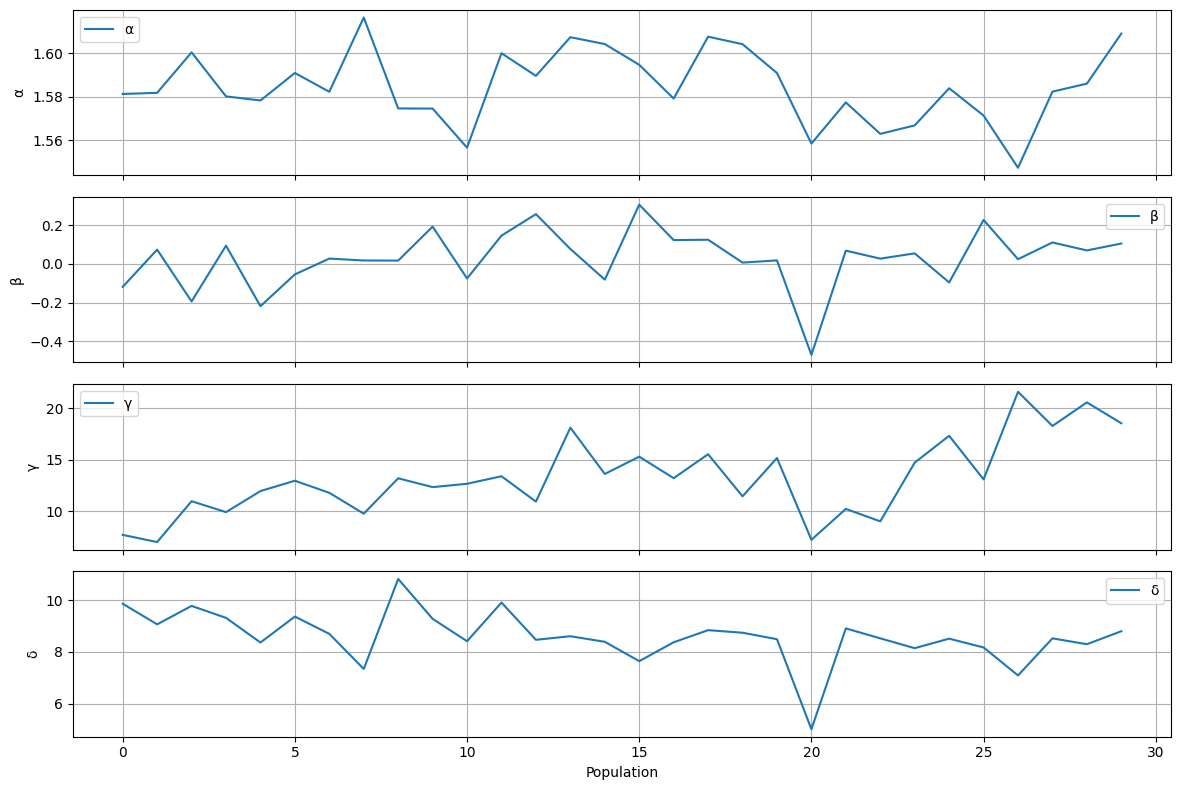

In [51]:
# Créer une figure avec 4 sous-graphiques pour les traces des paramètres
fig, axes = plt.subplots(4, 1, figsize=(12, 8), sharex=True)

# Extraire les paramètres de chaque population
alphas = []
betas = []
gammas = []
deltas = []

for t, (particles, weights) in enumerate(pops):
    # Calculer la moyenne pondérée pour chaque paramètre
    alpha_mean = np.average([p['alpha'] for p in particles], weights=weights)
    beta_mean = np.average([p['beta'] for p in particles], weights=weights)
    gamma_mean = np.average([p['gamma'] for p in particles], weights=weights)
    delta_mean = np.average([p['delta'] for p in particles], weights=weights)
    
    alphas.append(alpha_mean)
    betas.append(beta_mean)
    gammas.append(gamma_mean)
    deltas.append(delta_mean)

# Tracer les traces
axes[0].plot(alphas, label='α')
axes[1].plot(betas, label='β')
axes[2].plot(gammas, label='γ')
axes[3].plot(deltas, label='δ')

# Ajouter les labels et titres
axes[0].set_ylabel('α')
axes[1].set_ylabel('β')
axes[2].set_ylabel('γ')
axes[3].set_ylabel('δ')
axes[3].set_xlabel('Population')

# Ajouter les légendes
for ax in axes:
    ax.legend()
    ax.grid(True)

plt.tight_layout()
plt.show()


The implemented algorithm is indeed an SMC (Sequential Monte Carlo) sampler with a PRC-ABC (Population-based Rejection Control Approximate Bayesian Computation) approach. Below are the characteristics that confirm this:

#### 1. SMC Structure:
- Use of successive populations (pops)
- Weighting of particles
- Progressive adjustment of acceptance thresholds ( $ \epsilon$ )

#### 2. PRC-ABC Components:
- Rejection based on distance between observed and simulated statistics
- Use of a Gaussian kernel for acceptance
- Population control via particle weights

#### 3. Specific Characteristics:
- Adaptation of acceptance thresholds
- Resampling of particles
- Propagation of particles via proposal kernels
- Calculation of summary statistics (McCulloch)

Thus, the algorithm combines the advantages of SMC (efficient parameter space exploration) with those of ABC (likelihood-free inference), while using population control to maintain particle diversity.


In [52]:
# Calcul des moyennes et écarts-types des paramètres
alpha_mean = np.mean(alphas)
alpha_std = np.std(alphas)
beta_mean = np.mean(betas)
beta_std = np.std(betas)
gamma_mean = np.mean(gammas)
gamma_std = np.std(gammas)
delta_mean = np.mean(deltas)
delta_std = np.std(deltas)

# Affichage des résultats
print(f"α: {alpha_mean:.3f} ({alpha_std:.3f})")
print(f"β: {beta_mean:.3f} ({beta_std:.3f})")
print(f"γ: {gamma_mean:.3f} ({gamma_std:.3f})")
print(f"δ: {delta_mean:.3f} ({delta_std:.3f})")


α: 1.585 (0.017)
β: 0.029 (0.151)
γ: 13.247 (3.680)
δ: 8.592 (1.002)


## Question 4 — ABC for Multivariate Alpha-Stable Distributions

This section extends the ABC framework to **multivariate alpha-stable distributions**, as outlined in the bonus question of the project.

Since the multivariate stable density is intractable, Approximate Bayesian Computation (ABC) is particularly suitable. We assume that we can simulate from the model, but cannot evaluate the likelihood $( p(y|\theta) $), especially in multivariate contexts.

We implement the following components:

- A multivariate generator based on a generalization of the Chambers-Mallows-Stuck (CMS) algorithm.
- A custom summary statistic tailored for multivariate data.
- A rejection-based ABC algorithm accepting parameters if the simulated summaries are close enough to those of the observed data.



### Multivariate CMS Generator

We consider symmetric multivariate alpha-stable distributions of the form:

$$
X = R \cdot A Z
$$

Where:
- $R$ is a positive scalar drawn from the univariate CMS stable generator.
- $Z$ is a random direction on the unit sphere.
- $A$ is the square-root matrix (e.g., Cholesky) of the dispersion matrix $\Sigma$.

This method produces samples from the multivariate alpha-stable distribution with stability parameter $\alpha \in (0, 2]$.

In [3]:
def sample_multivariate_alpha_stable(alpha, cov_matrix, size=1):
    """
    Génère des échantillons d'une loi alpha-stable symétrique multivariée.
    Basé sur le générateur CMS généralisé.

    Paramètres
    ----------
    alpha : float
        Stabilité de la loi (0 < alpha <= 2).
    cov_matrix : np.ndarray
        Matrice de dispersion (positive semi-définie), p x p.
    size : int
        Nombre d’échantillons à générer.

    Retour
    ------
    samples : np.ndarray
        Tableau de shape (size, p).
    """
    p = cov_matrix.shape[0]
    Z = np.random.normal(size=(size, p))  # vecteur isotrope
    Z = Z / np.linalg.norm(Z, axis=1, keepdims=True)

    # Générateur CMS scalaire
    U = np.random.uniform(-np.pi/2, np.pi/2, size)
    W = np.random.exponential(1, size)

    scalar_samples = np.sin(alpha * U) / (np.cos(U) ** (1/alpha)) * \
                     (np.cos((1 - alpha) * U) / W) ** ((1 - alpha) / alpha)

    # Produit par la racine de la matrice de dispersion
    L = np.linalg.cholesky(cov_matrix)
    return scalar_samples[:, None] * (Z @ L.T)


### Summary Statistics for Multivariate Data

We define the following summary statistics to compare simulated and observed samples:

- The **empirical mean vector** $\bar{X} = \frac{1}{n} \sum_{i=1}^n X_i$
- The **empirical covariance matrix** $\hat{\Sigma} = \frac{1}{n-1} \sum_{i=1}^n (X_i - \bar{X})(X_i - \bar{X})^\top$
- Optionally, **marginal McCulloch statistics** applied to each coordinate

These summaries are used to compute the distance between observed and simulated samples.


In [5]:
def multivariate_summary_stats(data):
    """
    Calcule des statistiques de résumé multivariées.
    data: shape (n_samples, dim)
    """
    means = np.mean(data, axis=0)
    stds = np.std(data, axis=0)
    cov = np.cov(data.T)
    return {
        "mean": means,
        "std": stds,
        "cov": cov
    }


### ABC-Rejection for Multivariate Stable Distributions

We implement a rejection-based ABC algorithm:

1. Draw parameters $\theta = (\alpha, \Sigma)$ from the prior.
2. Generate $n$ samples from the multivariate stable law using the CMS generator.
3. Compute summary statistics $S(Y)$ for simulated data and $S(Y^\star)$ for observed data.
4. Compute the Euclidean distance: $d(S(Y), S(Y^\star))$.
5. Accept $\theta$ if $d(S(Y), S(Y^\star)) < \varepsilon$.

This yields a set of accepted parameters approximating the posterior distribution $\pi(\theta \mid Y^\star)$.


In [22]:
def abc_reject_multivariate(y_star, alpha_range, cov_matrices, n_samples, epsilon):
    accepted = []
    y_star_stats = multivariate_summary_stats(y_star)

    while len(accepted) < n_samples:
        alpha = np.random.uniform(*alpha_range)
        cov = cov_matrices[np.random.randint(0, len(cov_matrices))]

        y_sim = sample_multivariate_alpha_stable(alpha, cov, size=len(y_star))
        y_sim_stats = multivariate_summary_stats(y_sim)

        # distance sur les moyennes uniquement, pour simplifier
        dist = np.linalg.norm(y_sim_stats["mean"] - y_star_stats["mean"])
        
        if dist < epsilon:
            accepted.append({"alpha": alpha, "cov": cov, "distance": dist})

    return accepted
